<a href="https://colab.research.google.com/github/martinloretzzz/mlp-activation-ratios/blob/main/MLPActivationRatio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring the activation ratios of MLPs layers

## MNIST

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import pandas as pd
import numpy as np

pd.set_option('display.expand_frame_repr', False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

csv_file = 'mnist.csv'

def get_dataloader(dataset_name, batch_size=64):
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    if dataset_name == 'MNIST':
        train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        val_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    elif dataset_name == 'FashionMNIST':
        train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        val_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

class SimpleMLP(nn.Module):
    def __init__(self, layers):
        super(SimpleMLP, self).__init__()
        layers_list = []
        for i in range(len(layers) - 1):
            layers_list.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers) - 2:  # No ReLU at the last layer
                layers_list.append(nn.ReLU(inplace=True))
        self.model = nn.Sequential(*layers_list)

    def forward(self, x):
        return self.model(x)

def calculate_activation_ratio(layer_output):
    return (layer_output > 0).sum().item() / layer_output.numel()

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    epoch_loss, correct, total = 0.0, 0, 0
    all_activation_ratios = []

    for data, target in loader:
        data, target = data.view(data.size(0), -1).to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)

        layer_activation_ratios = []
        for layer in model.model:
            if isinstance(layer, nn.ReLU):
                continue
            elif isinstance(layer, nn.Linear):
                activations = layer(data)
                activation_ratio = calculate_activation_ratio(activations)
                layer_activation_ratios.append(activation_ratio)
                data = F.relu(activations)
        all_activation_ratios.append(layer_activation_ratios)

    accuracy = correct / total
    avg_loss = epoch_loss / len(loader)
    avg_activation_ratio = np.mean(all_activation_ratios, axis=0)

    return avg_loss, accuracy, avg_activation_ratio

def evaluate(model, loader, criterion):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.view(data.size(0), -1).to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)

    accuracy = correct / total
    avg_loss = val_loss / len(loader)

    return avg_loss, accuracy

def train_and_log_results(datasets, models, epochs=20, batch_size=64):

    for dataset_name in datasets:
        train_loader, val_loader = get_dataloader(dataset_name, batch_size)

        for model_layers in models:
            model_name = "=>".join(map(str, model_layers))
            model = SimpleMLP(model_layers).to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters())

            for epoch in range(1, epochs + 1):
                train_loss, train_acc, activation_ratio = train_epoch(model, train_loader, criterion, optimizer)
                val_loss, val_acc = evaluate(model, val_loader, criterion)

                model_data = {
                    'Dataset': dataset_name,
                    'Model': model_name,
                    'Epoch': epoch,
                    'Train Accuracy': train_acc,
                    'Val Accuracy': val_acc,
                    'Train Loss': train_loss,
                    'Val Loss': val_loss
                }

                epoch_data = []
                for i, ratio in enumerate(activation_ratio):
                    epoch_data.append({
                        **model_data,
                        'Layer': i+1,
                        'Activation Ratio': round(ratio, 4),
                        'Neuron Count': model_layers[i+1],
                        'Active Count': round(ratio * model_layers[i+1], 2)
                    })

                df = pd.DataFrame(epoch_data)
                print(df)
                df.to_csv(csv_file, mode='a', header=not pd.io.common.file_exists(csv_file), index=False)


datasets = ['MNIST', 'FashionMNIST'] # 'MNIST', 'FashionMNIST'
models = [
    [784, 512, 256, 128, 64, 10],  # 512 => 256 => 128 => 64 => 10
    [784, 256, 128, 64, 10],       # 256 => 128 => 64 => 10
    [784, 128, 64, 10],            # 128 => 64 => 10
    [784, 512, 128, 10],           # 512 => 128 => 10
    [784, 1024, 256, 64, 10],      # 1024 => 256 => 64 => 10
    [784, 64, 32, 10]              # 64 => 32 => 10
]

train_and_log_results(datasets, models, epochs=20, batch_size=64)

# train_and_log_results(['MNIST'], [[784, 128, 64, 10]], epochs=20, batch_size=64)

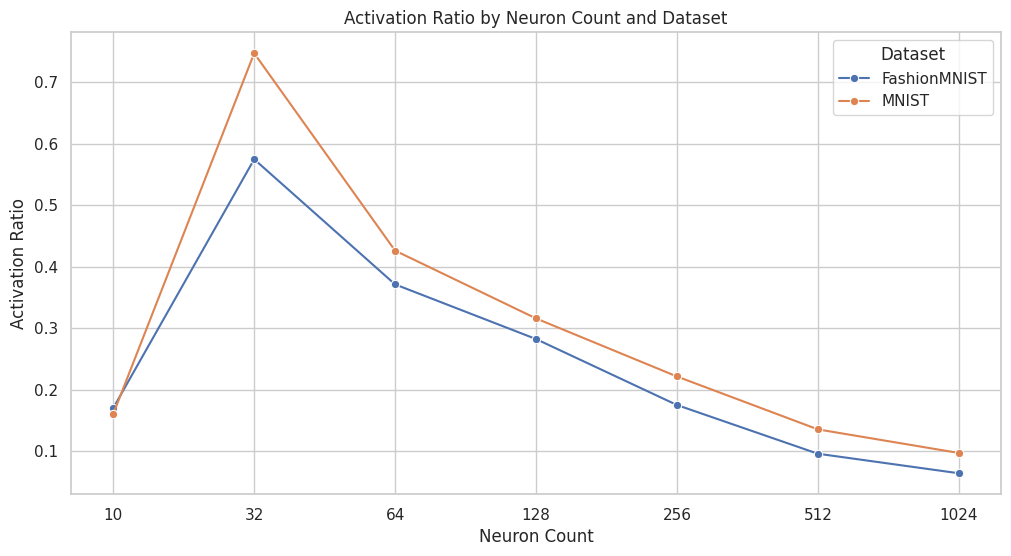

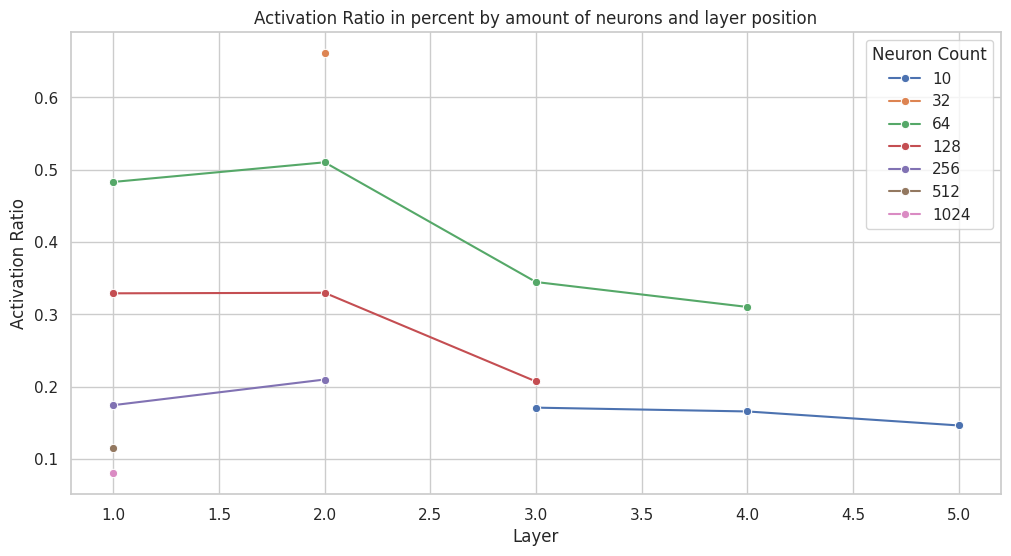

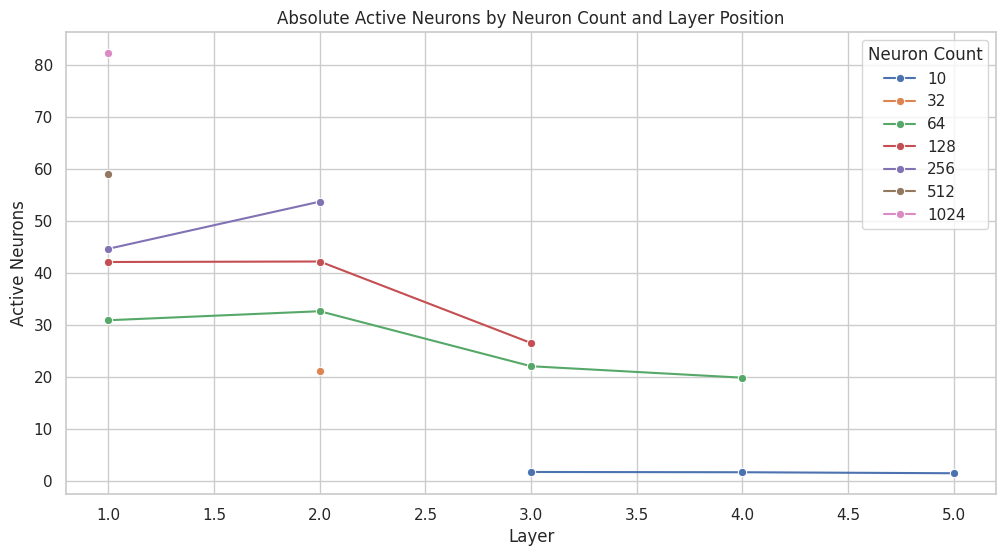

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid")

df = pd.read_csv('mnist.csv')

df_last = df[df['Epoch'] == 20]

df_activation_ratio = df_last.groupby(['Dataset', 'Neuron Count'])['Activation Ratio'].mean().reset_index()
df_activation_ratio['Neuron Count'] = df_activation_ratio['Neuron Count'].astype(str)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_activation_ratio, x='Neuron Count', y='Activation Ratio', hue='Dataset', marker='o')
plt.title('Activation Ratio by Neuron Count and Dataset')
plt.show()

df_activation_ratio = df_last.groupby(['Neuron Count', 'Layer'])['Activation Ratio'].mean().reset_index()
df_activation_ratio['Neuron Count'] = df_activation_ratio['Neuron Count'].astype(str)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_activation_ratio, x='Layer', y='Activation Ratio', hue='Neuron Count', marker='o')
plt.title('Activation Ratio in percent by amount of neurons and layer position')
plt.show()

df_activation_ratio = df_last.groupby(['Neuron Count', 'Layer'])['Activation Ratio'].mean().reset_index()
df_activation_ratio['Active Neurons'] = df_activation_ratio['Activation Ratio'] * df_activation_ratio['Neuron Count']
df_activation_ratio['Neuron Count'] = df_activation_ratio['Neuron Count'].astype(str)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_activation_ratio, x='Layer', y='Active Neurons', hue='Neuron Count', marker='o')
plt.title('Absolute Active Neurons by Neuron Count and Layer Position')
plt.show()

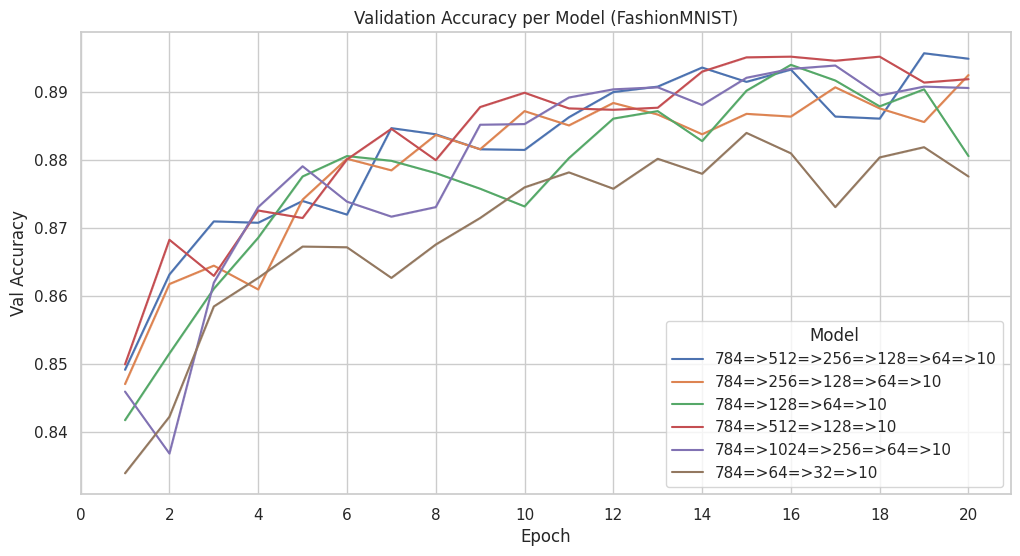

In [14]:
df_fashion = df[df['Dataset'] == 'FashionMNIST']

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_fashion, x='Epoch', y='Val Accuracy', hue='Model')
plt.title('Validation Accuracy per Model (FashionMNIST)')
plt.xticks(range(0, 21, 2))
plt.legend(title='Model', loc='lower right')
plt.show()

In [15]:
dfn = df[(df['Dataset'] == 'FashionMNIST') & (df['Epoch'] == 20)].groupby('Neuron Count')['Activation Ratio'].mean().reset_index()
dfn.columns = ['Neuron Count', 'Activation Ratio']

# Activated Neuron Estimation A = fit_factor * sqrt(N), where N = neuron count of layer
fit_factor = 3.2 # MNIST=3.6, FashionMNIST=3.2

dfn["Absoulute"] = (dfn['Neuron Count'] * dfn['Activation Ratio']).round(2)
dfn["Predicted"] = (fit_factor * np.sqrt(dfn['Neuron Count'])).round(2)
dfn["Diff"] = dfn["Predicted"] - dfn["Absoulute"]
dfn["Absoulute Round 8"] = (dfn["Absoulute"] / 8).round().astype(int) * 8

print(dfn)

   Neuron Count  Activation Ratio  Absoulute  Predicted   Diff  \
0            10          0.170067       1.70      10.12   8.42   
1            32          0.574900      18.40      18.10  -0.30   
2            64          0.371240      23.76      25.60   1.84   
3           128          0.282325      36.14      36.20   0.06   
4           256          0.174967      44.79      51.20   6.41   
5           512          0.095700      49.00      72.41  23.41   
6          1024          0.063900      65.43     102.40  36.97   

   Absoulute Round 8  
0                  0  
1                 16  
2                 24  
3                 40  
4                 48  
5                 48  
6                 64  


## Transformer

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, GPT2Model, GPT2Tokenizer
import numpy as np
import pandas as pd

def test_model(tokenizer, model, input_texts, device):
    model.to(device)

    activations = {}

    def get_activation(name):
        def hook(model, input, output):
            # print(output.shape)
            if name not in activations:
                activations[name] = []
            activations[name].append(output.detach())
        return hook

    hooks = []
    for i, block in enumerate(model.h if hasattr(model, 'h') else model.transformer.h):
        activation = block.mlp.act
        hook = activation.register_forward_hook(get_activation(str(i)))
        hooks.append(hook)

    for input_text in input_texts:
        input_ids = tokenizer(input_text, return_tensors='pt').input_ids.to(device)

        with torch.no_grad():
            model(input_ids)

    def calculate_activation_ratio(activations, threshold=0):
        activation_ratio = []
        for layer_name, activation_list in activations.items():
            active_neurons, total_neurons = 0, 0
            for i, activation in enumerate(activation_list):
                ratio = torch.sum(activation > threshold).item() / activation.numel()
                # print(ratio)
                activation_ratio.append({'layer': layer_name, 'input': i, 'activation_ratio': ratio})

        return activation_ratio

    activation_ratio = calculate_activation_ratio(activations)

    for hook in hooks:
        hook.remove()

    del model
    del activations
    torch.cuda.empty_cache()

    return activation_ratio


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gpt_csv_file = 'gpt.csv'
input_texts = [
    "The quick brown fox jumps over the lazy dog.",
    "Artificial intelligence is transforming the world.",
    "Once upon a time in a faraway land, there was a king.",
    "The stock market crashed yesterday, leading to a significant loss."
]

models = [
    ('gpt2', GPT2Model.from_pretrained('gpt2'), GPT2Tokenizer.from_pretrained('gpt2')),
    ('gpt2-medium', GPT2Model.from_pretrained('gpt2-medium'), GPT2Tokenizer.from_pretrained('gpt2-medium')),
    ('gpt2-large', GPT2Model.from_pretrained('gpt2-large'), GPT2Tokenizer.from_pretrained('gpt2-large')),
    ('gpt2-xl', GPT2Model.from_pretrained('gpt2-xl'), GPT2Tokenizer.from_pretrained('gpt2-xl')),
    ('gpt-neo-1.3B', AutoModelForCausalLM.from_pretrained('EleutherAI/gpt-neo-1.3B'), AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-1.3B')),
    ('gpt-neo-2.7B', AutoModelForCausalLM.from_pretrained('EleutherAI/gpt-neo-2.7B'), AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-2.7B')),
    ('gpt-j-6B', AutoModelForCausalLM.from_pretrained('EleutherAI/gpt-j-6B', torch_dtype=torch.float16), AutoTokenizer.from_pretrained('EleutherAI/gpt-j-6B')),
]

for (name, model, tokenizer) in models:
    activation_ratio = test_model(tokenizer, model, input_texts, device)

    df = pd.DataFrame(activation_ratio)
    df.insert(0, 'model', name)

    print(df)
    df.to_csv(gpt_csv_file, mode='a', header=not pd.io.common.file_exists(gpt_csv_file), index=False)


In [ ]:
# gpt2: Embed 768, FF Hidden: 3072
# gpt2-xl: Embed 1600, FF Hidden: 6400
# EleutherAI/gpt-neo-1.3B: Embed 2048, FF Hidden: 8192
# EleutherAI/gpt-neo-2.7B: Embed 2560, FF Hidden: 10240
# EleutherAI/gpt-j-6B: Embed 4096, FF Hidden: 16384

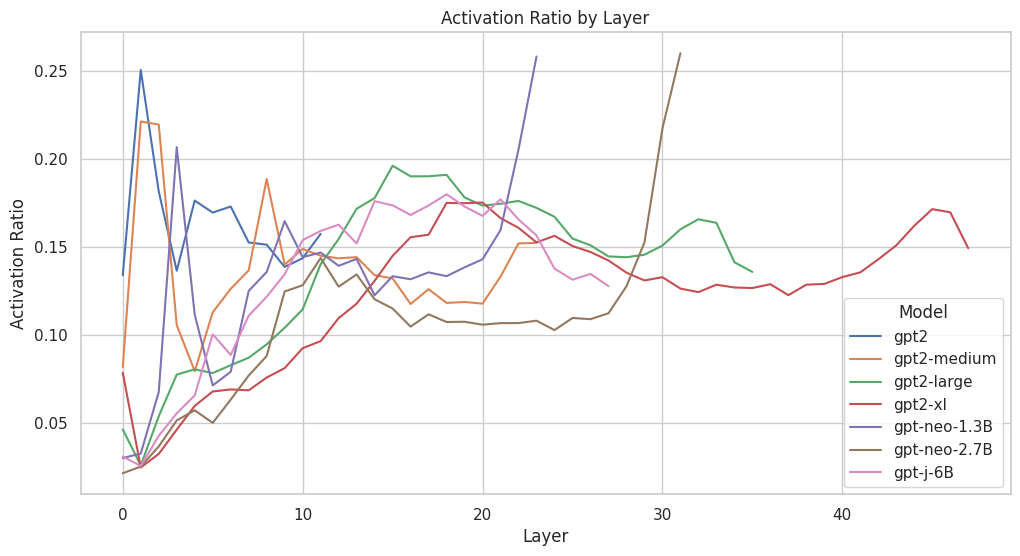

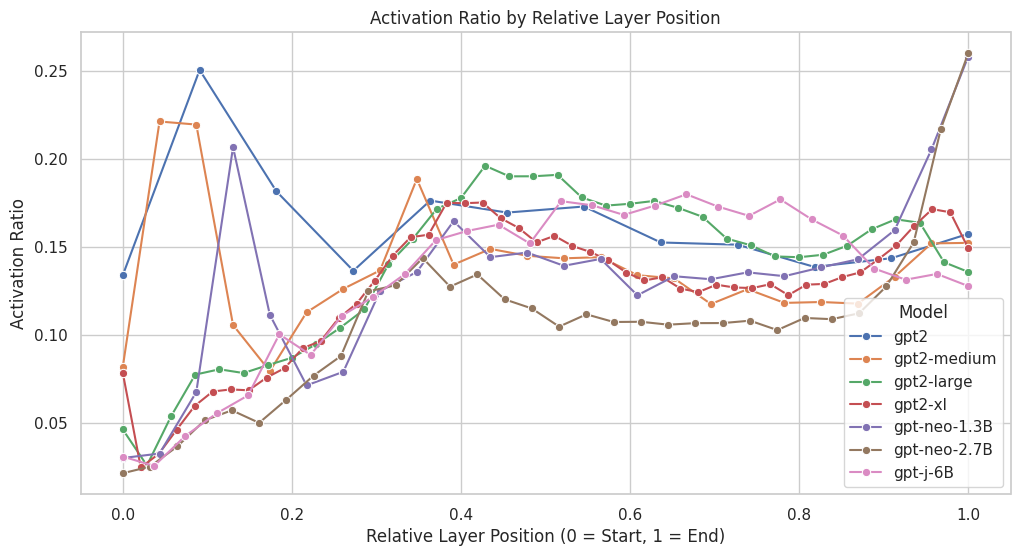

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('gpt.csv')
df = df.groupby(['model', 'layer'], sort=False).mean().reset_index()


plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='layer', y='activation_ratio', hue='model')
plt.xlabel('Layer')
plt.ylabel('Activation Ratio')
plt.title('Activation Ratio by Layer')
plt.legend(title='Model', loc='lower right')
plt.grid(True)
plt.show()

df['relative_layer'] = df.groupby('model')['layer'].transform(lambda x: x / x.max())
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='relative_layer', y='activation_ratio', hue='model', marker='o')
plt.xlabel('Relative Layer Position (0 = Start, 1 = End)')
plt.ylabel('Activation Ratio')
plt.title('Activation Ratio by Relative Layer Position')
plt.legend(title='Model', loc='lower right')
plt.grid(True)
plt.show()